# Not Quite Rainbow

In [0]:
# !apt install xvfb python-opengl ffmpeg -y > /dev/null 2>&1
# !pip install pyvirtualdisplay > /dev/null 2>&1
# !pip install -U torch > /dev/null 2>&1
# !pip install git+git://github.com/maximecb/gym-minigrid.git@master#egg=gym-minigrid > /dev/null 2>&1

!pip uninstall gym-minigrid gym
!pip install git+git://github.com/floringogianu/gym-minigrid.git@poli#egg=gym-minigrid > /dev/null 2>&1
print("\nRuntime > Restart Runtime after this cell executes!")

In [0]:
import itertools
import random
from argparse import Namespace
from collections import deque, defaultdict
from copy import deepcopy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as O
from torchvision import transforms as T
from PIL import Image
import gym
import gym_minigrid
from gym_minigrid.wrappers import RGBImgPartialObsWrapper, ImgObsWrapper, ReseedWrapper

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"OpenAI Gym: {gym.__version__}. \t\tShould be: ~0.15.x")
print(f"PyTorch   : {torch.__version__}.  \tShould be: >=1.2.x+cu100")
print(f"DEVICE    : {DEVICE}. \t\tShould be: cuda")

OpenAI Gym: 0.15.3. 		Should be: ~0.15.x
PyTorch   : 1.3.0+cu100.  	Should be: >=1.2.x+cu100
DEVICE    : cuda. 		Should be: cuda


In [0]:
def reset_rng(seed=42):
    print(f"Setting all rngs to seed={seed}")
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

reset_rng()

Setting all rngs to seed=42


In [0]:
envs = Namespace(
    easy="MiniGrid-Empty-5x5-v0",
    maze="MiniGrid-SimpleCrossingS9N1-v0",
    two_maze="MiniGrid-SimpleCrossingS9N2-v0",
    large_maze="MiniGrid-SimpleCrossingS11N1-v0",
    overestimation="MiniGrid-OverEstimation-9x9-v0",
    random_overestimation="MiniGrid-OverEstimation-Random-9x9-v0",
    fetch="MiniGrid-Fetch-8x8-N3-v0"
)

In [0]:
# Define some helpers: Gym Wrappers and visualization functions

class TorchWrapper(gym.ObservationWrapper):
    """ Applies a couple of transformations depending on the mode.
        Receives numpy arrays and returns torch tensors.
    """

    def __init__(self, env):
        super().__init__(env)
        self._transform = T.Compose([
            lambda obs: (obs * int(255 / 9)).swapaxes(1, 0),
            lambda obs: torch.from_numpy(obs).permute(2, 1, 0)
        ])
    
    def observation(self, obs):
        return self._transform(obs).unsqueeze(0).to(DEVICE)


class FrameStack(gym.Wrapper):
    """Stack k last frames. """

    def __init__(self, env, k, verbose=False):
        super().__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)

    def reset(self):
        observation = self.env.reset()
        for _ in range(self.k):
            self.frames.append(observation)
        return self._get_ob()

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self.frames.append(observation)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        if self.k == 1:
            return self.frames.pop()
        return np.concatenate(list(self.frames), axis=2)


def show_representations(env_name="MiniGrid-SimpleCrossingS9N1-v0", tile_size=8):
    seed = torch.randint(100, (1,)).item()

    env = ImgObsWrapper(RGBImgPartialObsWrapper(gym.make(env_name), tile_size=tile_size))
    print("Action-space: ", env.action_space.n)
    env.seed(seed)
    rgb_obs = env.reset()

    env = ImgObsWrapper(gym.make(env_name))
    env.seed(seed)
    sym_obs = env.reset()

    print("RGB:", rgb_obs.shape)
    print("SYM:", sym_obs.shape)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 36))
    ax1.imshow(rgb_obs)
    ax2.imshow((sym_obs * int(255 / 9)).swapaxes(1, 0))
    ax3.imshow(env.render(mode="rgb_array"))


def plot_stats(stats, y="ep_rewards", hue=None, window=10):
    df = pd.DataFrame(stats)

    if window:
        new_col = f"avg_{y}"
        if hue is not None:
            df[new_col] = df.groupby(hue)[y].rolling(window=window).mean().reset_index(0,drop=True)
        else:
            df[new_col] = df[y].rolling(window=window).mean()
    
    y = f"avg_{y}" if window else y
    with matplotlib.rc_context({'figure.figsize':(10, 6)}):
        sns.lineplot(x="step_idx", y=y, hue=hue, data=df)

## Let's take a look at the environments

In [0]:
for k, v in vars(envs).items():
    print(f"{k:<24}: {v}")

easy                    : MiniGrid-Empty-5x5-v0
maze                    : MiniGrid-SimpleCrossingS9N1-v0
two_maze                : MiniGrid-SimpleCrossingS9N2-v0
large_maze              : MiniGrid-SimpleCrossingS11N1-v0
overestimation          : MiniGrid-OverEstimation-9x9-v0
random_overestimation   : MiniGrid-OverEstimation-Random-9x9-v0
fetch                   : MiniGrid-Fetch-8x8-N3-v0


Action-space:  7
RGB: (56, 56, 3)
SYM: (7, 7, 3)


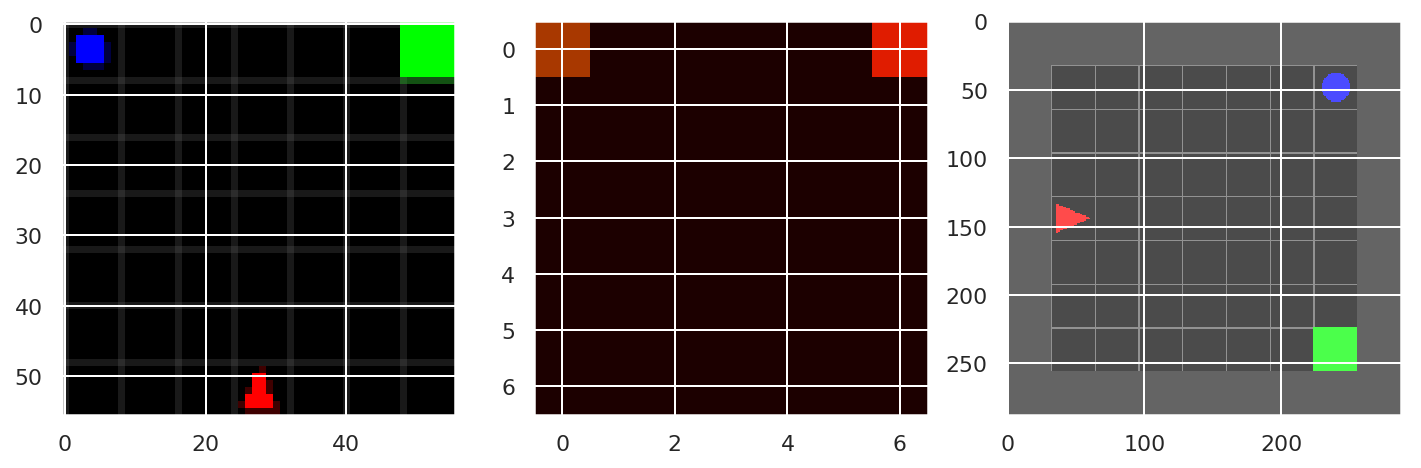

In [0]:
# you can execute this a few times to get an idea about the two possible
# views of the agent
show_representations(envs.overestimation, tile_size=8)

## Let's define the training routine.

It takes an agent and an environment and implements the action-perception loop.

In [0]:
def train(agent, env, step_num=100_000):
    
    stats, N = {"step_idx": [0], "ep_rewards": [0.0], "ep_steps": [0.0]}, 0

    state, done = env.reset().clone(), False
    for step in range(step_num):

        action = agent.step(state)
        state_, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, state_, done)

        # some envs just update the state and are not returning a new one
        state = state_.clone()

        # stats
        stats["ep_rewards"][N] += reward
        stats["ep_steps"][N] += 1

        if done:
            # episode done, reset env!
            state, done = env.reset().clone(), False
        
            # some more stats
            if N % 10 == 0:
                print("[{0:3d}][{1:6d}], R/ep={2:6.2f}, steps/ep={3:2.0f}.".format(
                    N, step,
                    torch.tensor(stats["ep_rewards"][-10:]).mean().item(),
                    torch.tensor(stats["ep_steps"][-10:]).mean().item(),
                ))

            stats["ep_rewards"].append(0.0)  # reward accumulator for a new episode
            stats["ep_steps"].append(0.0)    # reward accumulator for a new episode
            stats["step_idx"].append(step)
            N += 1

    print("[{0:3d}][{1:6d}], R/ep={2:6.2f}, steps/ep={3:2.0f}.".format(
        N, step, torch.tensor(stats["ep_rewards"][-10:]).mean().item(),
        torch.tensor(stats["ep_steps"][-10:]).mean().item(),
    ))
    stats["agent"] = [agent.__class__.__name__ for _ in range(N+1)]
    return stats

## Start implementing the DQN agent

## 1. Experience Replay

#### TASK 1: implement `sample` method.

In [0]:
class ReplayMemory:
    def __init__(self, size=1000, batch_size=32):
        self._buffer = deque(maxlen=size)
        self._batch_size = batch_size
    
    def push(self, transition):
        self._buffer.append(transition)
    
    def sample(self):
        """ Sample from self._buffer

            Should return a tuple of tensors of size: 
            (
                states:     N * (C*K) * H * W,  (torch.uint8)
                actions:    N * 1, (torch.int64)
                rewards:    N * 1, (torch.float32)
                states_:    N * (C*K) * H * W,  (torch.uint8)
                done:       N * 1, (torch.uint8)
            )

            where N is the batch_size, C is the number of channels = 3 and
            K is the number of stacked states.
        """
        # sample
        # s, a, r, s_, d = 

        # reshape, convert if needed, put on device (use torch.to(DEVICE))
        pass    

    def __len__(self):
        return len(self._buffer)

## 2. $\epsilon$-greedy schedule.

#### TASK 2: Implement the epsilon-greedy schedule

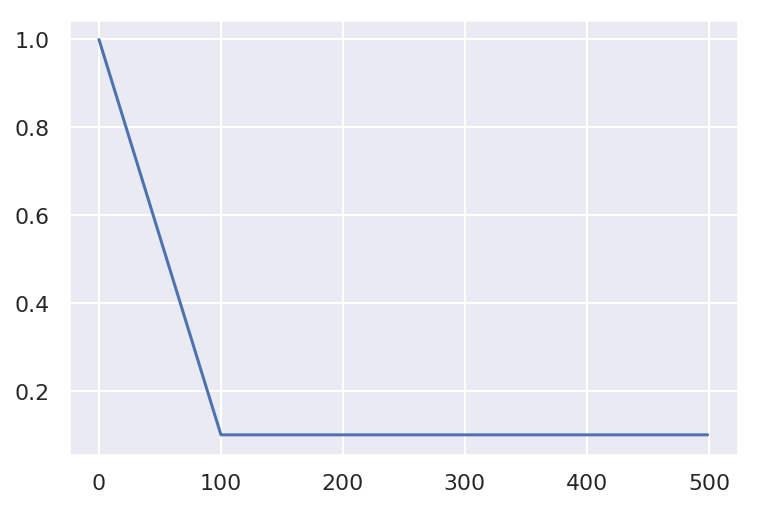

In [0]:
def get_epsilon_schedule(start=1.0, end=0.1, steps=500):
    """ Returns either:
        - a generator of epsilon values
        - a function that receives the current step and returns an epsilon

        The epsilon values returned by the generator or function need
        to be degraded from the `start` value to the `end` within the number 
        of `steps` and then continue returning the `end` value indefinetly.

        You can pick any schedule (exp, poly, etc.). I tested with linear decay.
    """
    pass


# test it, it needs to look nice
epsilon = get_epsilon_schedule(1.0, 0.1, 100)
plt.plot([next(epsilon) for _ in range(500)])

# or if you prefer a function
# epsilon_fn = get_epsilon_schedule(1.0, 0.1, 100)
# plt.plot([epsilon(step_idx) for step_idx in range(500)])

### Define a Neural Network Approximator for your Agents

In [0]:
class ByteToFloat(nn.Module):
    """ Converts ByteTensor to FloatTensor and rescales.
    """
    def forward(self, x):
        assert (
            x.dtype == torch.uint8
        ), "The model expects states of type ByteTensor."
        return x.float().div_(255)


class View(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


def get_estimator(action_num, input_ch=3, lin_size=32):
    return nn.Sequential(
        ByteToFloat(),
        nn.Conv2d(input_ch, 16, kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 16, kernel_size=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(16, 16, kernel_size=2),
        nn.ReLU(inplace=True),
        View(),
        nn.Linear(9 * 16, lin_size),
        nn.ReLU(inplace=True),
        nn.Linear(lin_size, action_num),
    ).to(DEVICE)

## 3. DQN Agent, finally

#### TASK 3: 
- implement the `step()` method
- implement the `learn()` method
- implement the `_update()` method

In [0]:
class DQN:
    def __init__(
        self,
        estimator,
        buffer,
        optimizer,
        epsilon_schedule,
        action_num,
        gamma=0.92,
        update_steps=4,
        update_target_steps=10,
        warmup_steps=100,
    ):
        self._estimator = estimator
        self._target_estimator = deepcopy(estimator)
        self._buffer = buffer
        self._optimizer = optimizer
        self._epsilon = epsilon_schedule
        self._action_num = action_num
        self._gamma = gamma
        self._update_steps=update_steps
        self._update_target_steps=update_target_steps
        self._warmup_steps = warmup_steps
        self._step_cnt = 0
        assert warmup_steps > self._buffer._batch_size, (
            "You should have at least a batch in the ER.")
    
    def step(self, state):
        # implement an epsilon greedy policy using the
        # estimator and epsilon schedule attributes.

        # warning, you should make sure you are not including
        # this step into torch computation graph
        
        if self._step_cnt < self._warmup_steps:
            return torch.randint(self._action_num, (1,)).item()

        # return the action according to the self._epsilon schedule
        # you defined earlier
        pass

    def learn(self, state, action, reward, state_, done):

        # TODO: add transition to the experience replay

        if self._step_cnt < self._warmup_steps:
            self._step_cnt += 1
            return

        # TODO: sample from experience replay and do an update
        if self._step_cnt % self._update_steps == 0:
            pass
        
        # TODO: update the target estimator (hint, use pytorch state_dict methods)

        self._step_cnt += 1

    def _update(self, states, actions, rewards, states_, done):
        # compute the DeepQNetwork update. Carefull not to include the
        # target network in the computational graph.

        # Compute Q(s, * | θ) and Q(s', . | θ^)
        # q_values = 
        # q_values_ = 
        
        # compute Q(s, a) and max_a' Q(s', a')
        # qsa = 
        # qsa_ = 

        # compute target values
        # target_qsa = 

        # at this step you should check the target values
        # are looking about right :). You can use this code.
        # if rewards.squeeze().sum().item() > 0.0:
        #     print("R: ", rewards.squeeze())
        #     print("T: ", target_qsa.squeeze())
        #     print("D: ", done.squeeze())

        # compute the loss and average it over the entire batch
        # loss = 

        # backprop and optimize
        pass


In [0]:
env = gym.make(envs.easy)
env = TorchWrapper(ImgObsWrapper(env))
net = get_estimator(env.action_space.n)

stats = train(
    DQN(
        net,
        ReplayMemory(size=1000, batch_size=32),
        O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
        get_epsilon_schedule(start=1.0, end=0.1, steps=4000),
        env.action_space.n,
        warmup_steps=100,
        update_steps=2,
    ),
    env,
    step_num=7_000  # change the experiment length if it's learning but not reaching about .95
)

[  0][    35], R/ep=  0.68, steps/ep=36.
[ 10][   808], R/ep=  0.25, steps/ep=77.
[ 20][  1516], R/ep=  0.33, steps/ep=71.
[ 30][  2021], R/ep=  0.53, steps/ep=50.
[ 40][  2337], R/ep=  0.72, steps/ep=32.
[ 50][  2784], R/ep=  0.59, steps/ep=45.
[ 60][  3363], R/ep=  0.46, steps/ep=58.
[ 70][  3730], R/ep=  0.65, steps/ep=37.
[ 80][  3824], R/ep=  0.92, steps/ep= 9.
[ 90][  3925], R/ep=  0.91, steps/ep=10.
[100][  4000], R/ep=  0.93, steps/ep= 8.
[110][  4072], R/ep=  0.94, steps/ep= 7.
[120][  4136], R/ep=  0.94, steps/ep= 6.
[130][  4194], R/ep=  0.95, steps/ep= 6.
[140][  4248], R/ep=  0.95, steps/ep= 5.
[150][  4304], R/ep=  0.95, steps/ep= 6.
[160][  4365], R/ep=  0.95, steps/ep= 6.
[170][  4430], R/ep=  0.94, steps/ep= 6.
[180][  4493], R/ep=  0.94, steps/ep= 6.
[190][  4555], R/ep=  0.94, steps/ep= 6.
[200][  4611], R/ep=  0.95, steps/ep= 6.
[210][  4664], R/ep=  0.95, steps/ep= 5.
[220][  4719], R/ep=  0.95, steps/ep= 6.
[230][  4772], R/ep=  0.95, steps/ep= 5.
[240][  4830], R

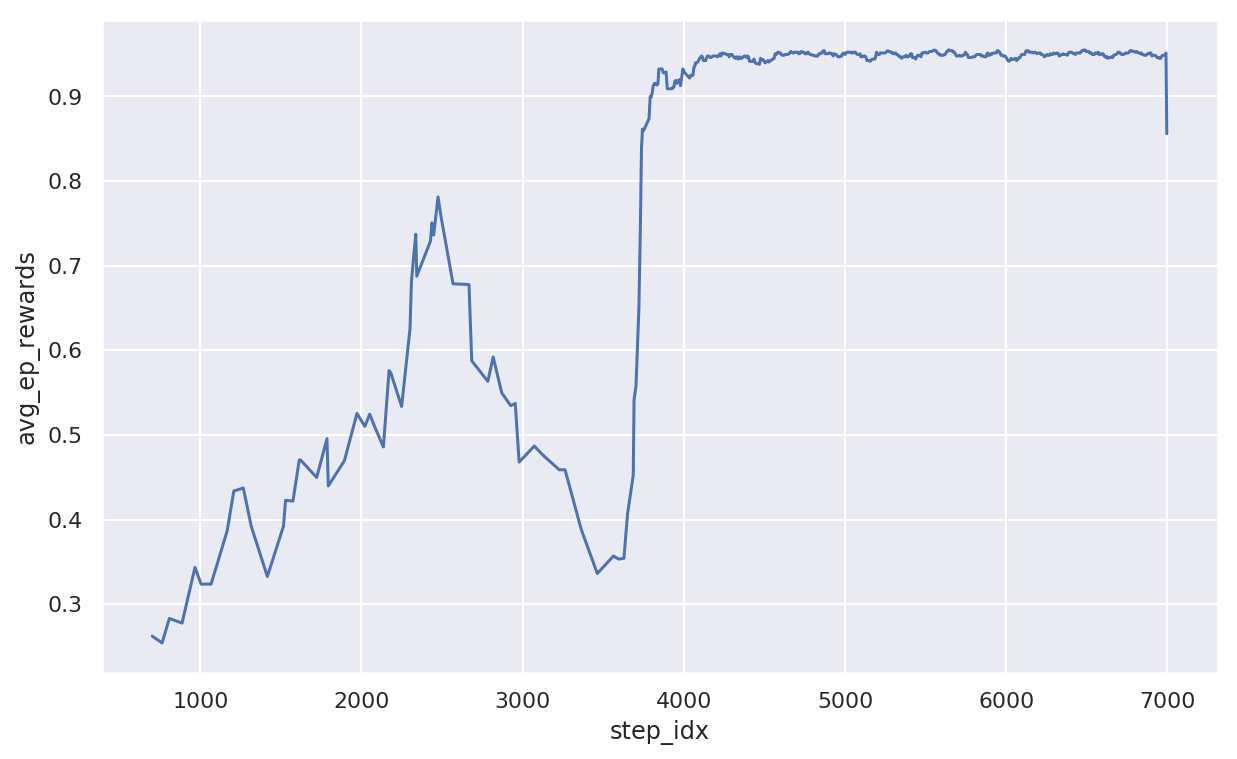

In [0]:
plot_stats(stats)

## 4. Train on a partial observable maze

Action-space:  7
RGB: (56, 56, 3)
SYM: (7, 7, 3)


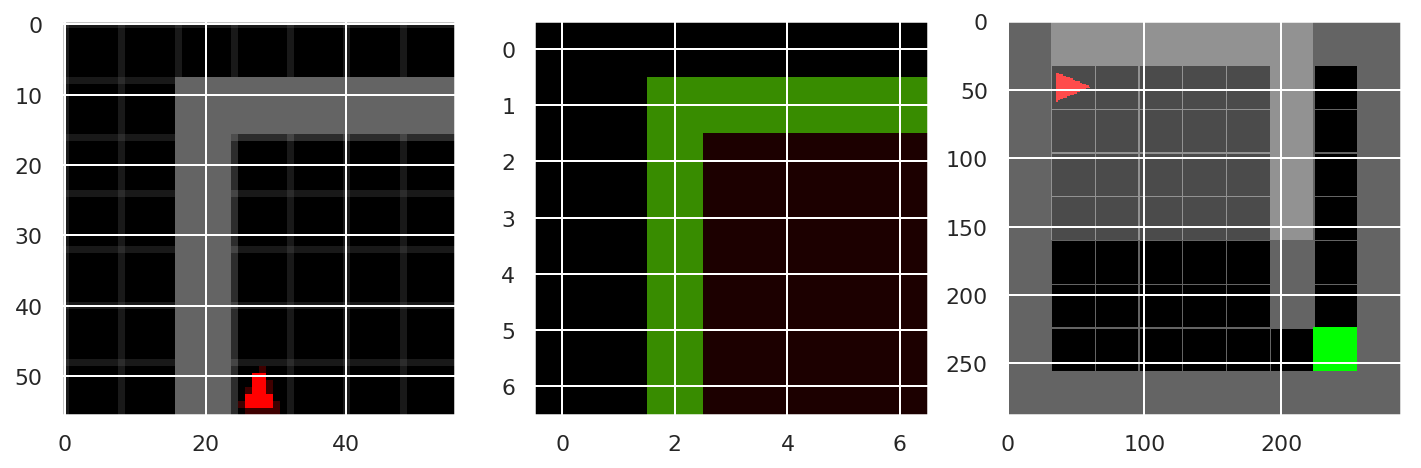

In [0]:
show_representations(envs.maze)
# show_representations(envs.large_maze)

In [0]:
step_num=30_000
seeds = [2, 5]          # add more map configurations
hist_len = [1, 2, 3]    # increase it to two and compare

common_seed = np.random.randint(1000)
stats = defaultdict(list)
for K in hist_len:
    print(f"Started training with hist_len={K}.")
    # 102 worked nicely here :))
    reset_rng(common_seed)  # we want each experiment to have the same starting conditions
 
    env = gym.make(envs.maze)
    env = TorchWrapper(FrameStack(ImgObsWrapper(ReseedWrapper(env, seeds=seeds)), k=K))
    net = get_estimator(env.action_space.n, input_ch=K*3, lin_size=64)
    
    stats_ = train(
        DQN(
            net,
            ReplayMemory(size=10_000, batch_size=32),
            O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
            get_epsilon_schedule(start=1.0, end=0.1, steps=10_000),
            env.action_space.n,
            warmup_steps=1000,
            update_steps=2,
            update_target_steps=8
        ),
        env,
        step_num=step_num
    )

    stats_["hist_len"] = [K] * len(stats_["ep_rewards"])
    for k, v in stats_.items():
        stats[k] += v

Started training with hist_len=1.
Setting all rngs to seed=102
[  0][   323], R/ep=  0.00, steps/ep=324.
[ 10][  3319], R/ep=  0.10, steps/ep=300.
[ 20][  6301], R/ep=  0.08, steps/ep=298.
[ 30][  9487], R/ep=  0.03, steps/ep=319.
[ 40][ 12279], R/ep=  0.15, steps/ep=279.
[ 50][ 15045], R/ep=  0.15, steps/ep=277.
[ 60][ 18285], R/ep=  0.00, steps/ep=324.
[ 70][ 21525], R/ep=  0.00, steps/ep=324.
[ 80][ 24451], R/ep=  0.11, steps/ep=293.
[ 90][ 26491], R/ep=  0.38, steps/ep=204.
[100][ 28527], R/ep=  0.38, steps/ep=204.
[105][ 29999], R/ep=  0.22, steps/ep=242.
Started training with hist_len=2.
Setting all rngs to seed=102
[  0][   323], R/ep=  0.00, steps/ep=324.
[ 10][  3387], R/ep=  0.06, steps/ep=306.
[ 20][  6438], R/ep=  0.06, steps/ep=305.
[ 30][  9252], R/ep=  0.15, steps/ep=281.
[ 40][ 11945], R/ep=  0.20, steps/ep=269.
[ 50][ 13902], R/ep=  0.43, steps/ep=196.
[ 60][ 14943], R/ep=  0.70, steps/ep=104.
[ 70][ 17290], R/ep=  0.30, steps/ep=235.
[ 80][ 19597], R/ep=  0.32, steps/

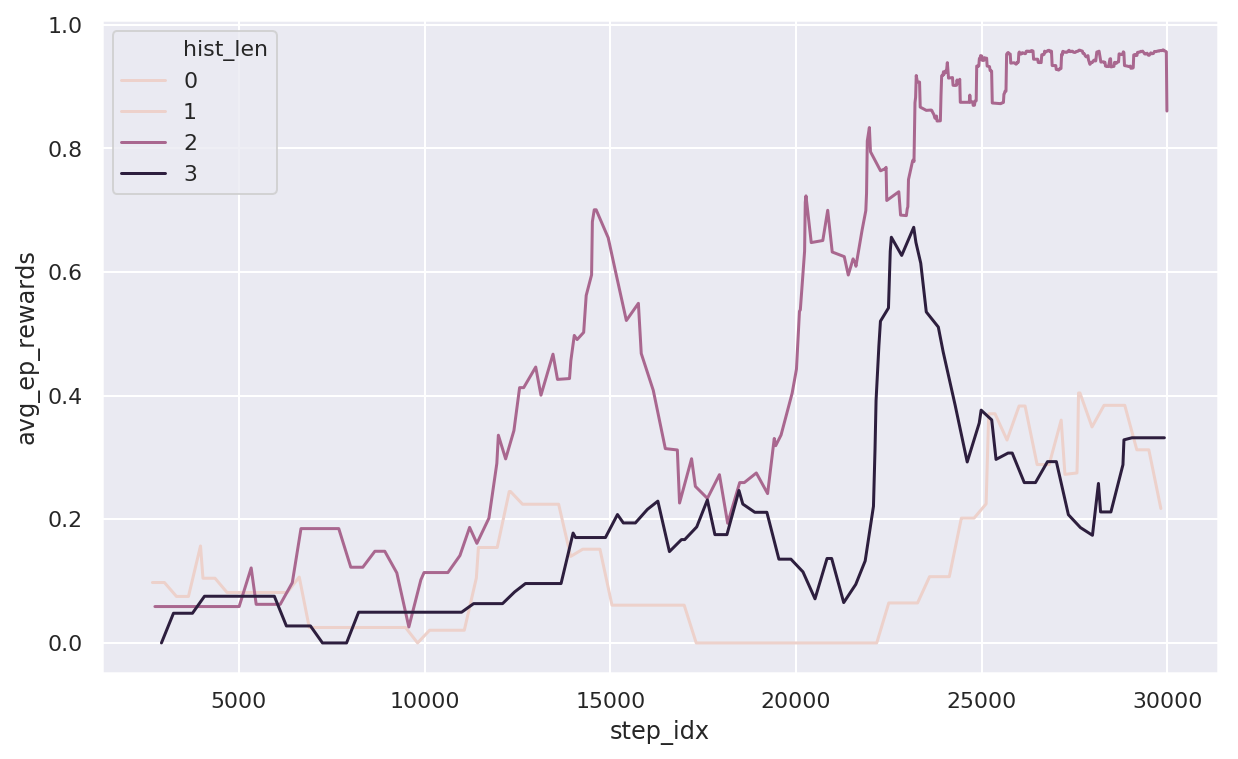

In [0]:
plot_stats(stats, hue="hist_len")

## 5. Double DQN


#### TASK 4: Implement the _update() method for DoubleDQN

In [0]:
class DoubleDQN(DQN):
    def _update(self, states, actions, rewards, states_, done):
        # compute the DeepQNetwork update. Carefull not to include the
        # target network in the computational graph.

        # Compute Q(s, * | θ) and Q(s', . | θ^)
        # q_values = 
        # q_values_ = 
        
        #... and the rest of it

In [0]:
env = gym.make(envs.easy)
env = TorchWrapper(ImgObsWrapper(env))
net = get_estimator(env.action_space.n)

stats = train(
    DoubleDQN(
        net,
        ReplayMemory(size=1000, batch_size=32),
        O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
        get_epsilon_schedule(start=1.0, end=0.1, steps=4000),
        env.action_space.n,
        warmup_steps=100,
        update_steps=2,
        update_target_steps=16
    ),
    env,
    step_num=7_000  # change the experiment length if it's learning but not reaching about .95
)

[  0][    38], R/ep=  0.65, steps/ep=39.
[ 10][   807], R/ep=  0.26, steps/ep=77.
[ 20][  1528], R/ep=  0.32, steps/ep=72.
[ 30][  2211], R/ep=  0.36, steps/ep=68.
[ 40][  2810], R/ep=  0.42, steps/ep=60.
[ 50][  3375], R/ep=  0.45, steps/ep=56.
[ 60][  3797], R/ep=  0.62, steps/ep=42.
[ 70][  3895], R/ep=  0.91, steps/ep=10.
[ 80][  3975], R/ep=  0.93, steps/ep= 8.
[ 90][  4077], R/ep=  0.91, steps/ep=10.
[100][  4145], R/ep=  0.94, steps/ep= 7.
[110][  4200], R/ep=  0.95, steps/ep= 6.
[120][  4262], R/ep=  0.94, steps/ep= 6.
[130][  4318], R/ep=  0.95, steps/ep= 6.
[140][  4376], R/ep=  0.95, steps/ep= 6.
[150][  4431], R/ep=  0.95, steps/ep= 6.
[160][  4498], R/ep=  0.94, steps/ep= 7.
[170][  4554], R/ep=  0.95, steps/ep= 6.
[180][  4609], R/ep=  0.95, steps/ep= 6.
[190][  4662], R/ep=  0.95, steps/ep= 5.
[200][  4718], R/ep=  0.95, steps/ep= 6.
[210][  4769], R/ep=  0.95, steps/ep= 5.
[220][  4829], R/ep=  0.95, steps/ep= 6.
[230][  4895], R/ep=  0.94, steps/ep= 7.
[240][  4959], R

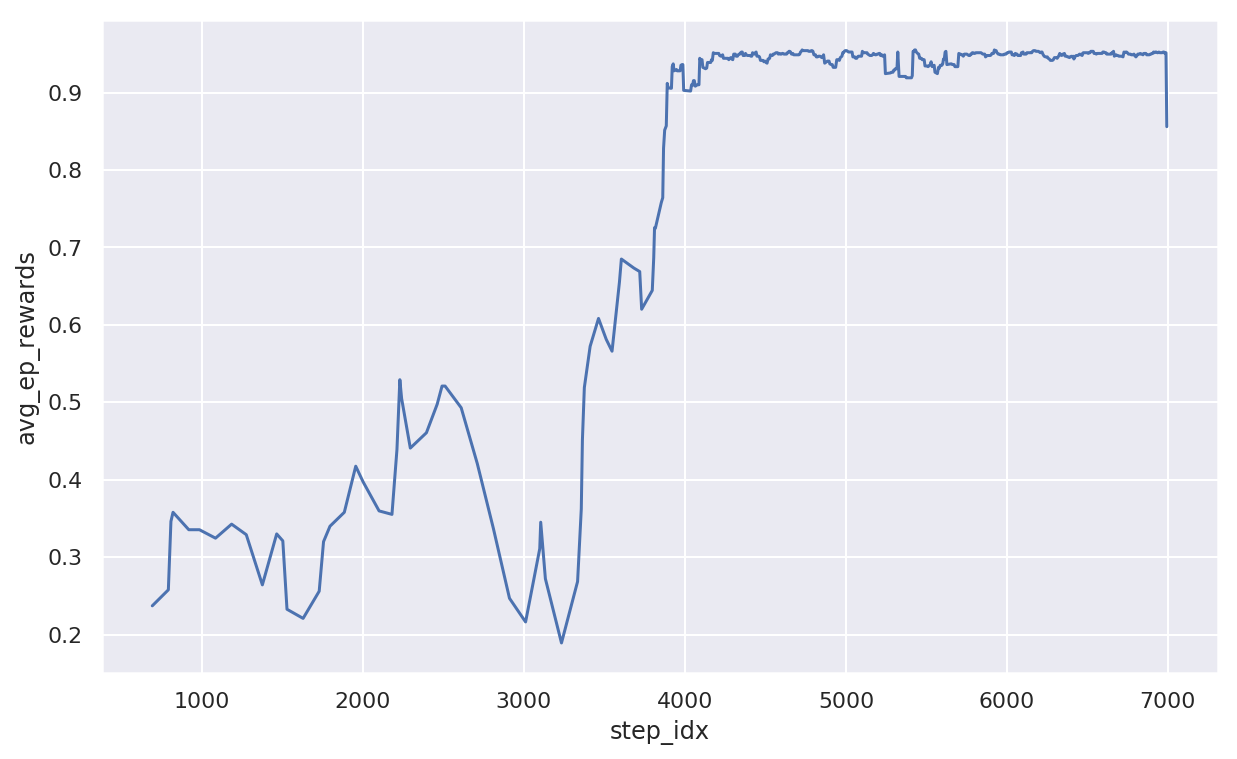

In [0]:
plot_stats(stats)

## 6. DQN vs Double DQN: OverEstimation environment

Action-space:  7
RGB: (56, 56, 3)
SYM: (7, 7, 3)
LUM: (56, 56)


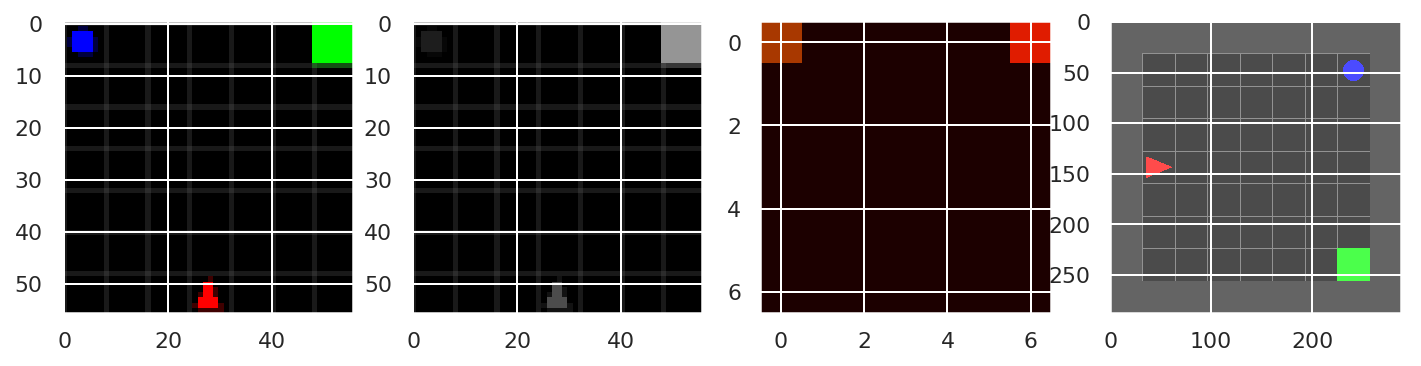

In [0]:
show_representations(envs.overestimation)

In [0]:
step_num = 20_000           # change the experiment length
stats = defaultdict(list)

common_seed = np.random.randint(1000)
for Agent in [DQN, DoubleDQN]:
    # 256 worked nicely here :))
    reset_rng(common_seed)  # we want each experiment to have the same starting conditions

    env = TorchWrapper(ImgObsWrapper(gym.make(envs.overestimation)))
    net = get_estimator(env.action_space.n)
    
    agent_name = Agent.__name__
    print(f"\n{agent_name} started training.")
    stats_ = train(
        Agent(
            net,
            ReplayMemory(size=5000, batch_size=32),
            O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
            get_epsilon_schedule(start=1.0, end=0.1, steps=5000),
            env.action_space.n,
            warmup_steps=3000,
            update_steps=2,
            update_target_steps=256
        ),
        env,
        step_num=step_num
    )

    for k, v in stats_.items():
        stats[k] += v

Setting all rngs to seed=256

DQN started training.
[  0][   114], R/ep=  0.68, steps/ep=115.
[ 10][  2763], R/ep=  0.72, steps/ep=265.
[ 20][  5310], R/ep=  0.00, steps/ep=255.
[ 30][  6676], R/ep=  0.74, steps/ep=137.
[ 40][  9018], R/ep=  0.26, steps/ep=234.
[ 50][ 10099], R/ep=  0.70, steps/ep=108.
[ 60][ 10967], R/ep=  0.90, steps/ep=87.
[ 70][ 11851], R/ep=  0.75, steps/ep=88.
[ 80][ 13593], R/ep=  0.04, steps/ep=174.
[ 90][ 14975], R/ep=  0.60, steps/ep=138.
[100][ 15259], R/ep=  0.92, steps/ep=28.
[110][ 15621], R/ep=  0.90, steps/ep=36.
[120][ 16349], R/ep=  0.80, steps/ep=73.
[130][ 16555], R/ep=  0.94, steps/ep=21.
[140][ 17055], R/ep=  0.86, steps/ep=50.
[150][ 17376], R/ep=  0.91, steps/ep=32.
[160][ 17768], R/ep=  0.89, steps/ep=39.
[170][ 17954], R/ep=  0.95, steps/ep=19.
[180][ 18081], R/ep=  0.96, steps/ep=13.
[190][ 18203], R/ep=  0.97, steps/ep=12.
[200][ 18483], R/ep=  0.92, steps/ep=28.
[210][ 18898], R/ep=  0.88, steps/ep=42.
[220][ 19016], R/ep=  0.97, steps/ep=1

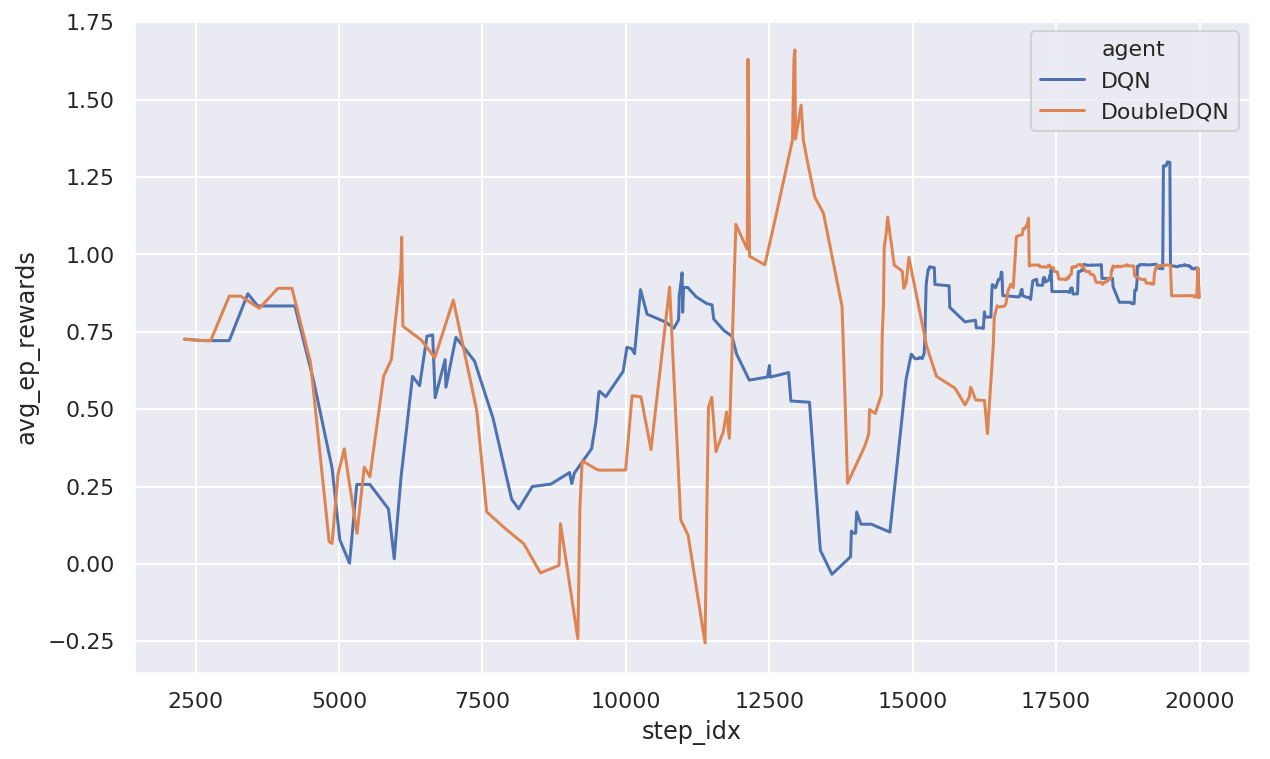

In [0]:
plot_stats(stats, hue="agent")

## 7. DQN vs DoubleDQN: Maze Environment

Action-space:  7
RGB: (56, 56, 3)
SYM: (7, 7, 3)
LUM: (56, 56)


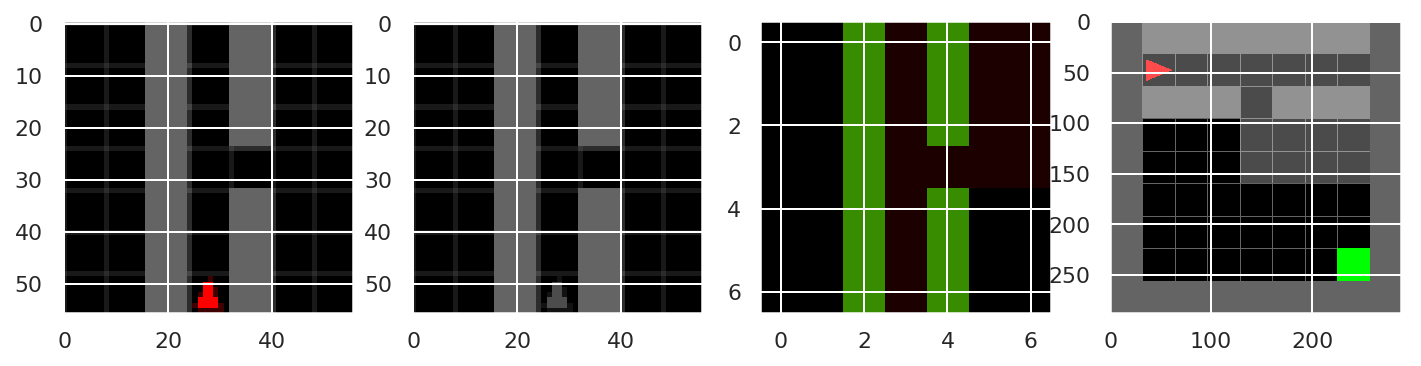

In [0]:
show_representations(envs.maze)

In [0]:
env_name = envs.maze
step_num = 50_000           # change the experiment length
seeds = [2, 5]              # add more maps
K = 2
stats = defaultdict(list)

common_seed = np.random.randint(1000)
for Agent in [DQN, DoubleDQN]:
    # maybe 621? :))
    reset_rng(common_seed)  # we want each experiment to have the same starting conditions

    env = gym.make(env_name)
    env = TorchWrapper(FrameStack(ImgObsWrapper(ReseedWrapper(env, seeds=seeds)), k=K))
    net = get_estimator(env.action_space.n, input_ch=K*3, lin_size=64)
    
    agent_name = Agent.__name__
    print(f"\n{agent_name} started training.")
    stats_ = train(
        Agent(
            net,
            ReplayMemory(size=10_000, batch_size=32),
            O.Adam(net.parameters(), lr=1e-3, eps=1e-4),
            get_epsilon_schedule(start=1.0, end=0.1, steps=10_000),
            env.action_space.n,
            warmup_steps=1000,
            update_steps=2,
            update_target_steps=256
        ),
        env,
        step_num=step_num
    )

    for k, v in stats_.items():
        stats[k] += v

Setting all rngs to seed=621

DQN started training.
[  0][   323], R/ep=  0.00, steps/ep=324.
[ 10][  3563], R/ep=  0.00, steps/ep=324.
[ 20][  6803], R/ep=  0.00, steps/ep=324.
[ 30][  9976], R/ep=  0.03, steps/ep=317.
[ 40][ 13216], R/ep=  0.00, steps/ep=324.
[ 50][ 16441], R/ep=  0.01, steps/ep=322.
[ 60][ 19681], R/ep=  0.00, steps/ep=324.
[ 70][ 22305], R/ep=  0.21, steps/ep=262.
[ 80][ 25478], R/ep=  0.03, steps/ep=317.
[ 90][ 28331], R/ep=  0.16, steps/ep=285.
[100][ 29738], R/ep=  0.59, steps/ep=141.
[110][ 31728], R/ep=  0.43, steps/ep=199.
[120][ 34530], R/ep=  0.14, steps/ep=280.
[130][ 37503], R/ep=  0.08, steps/ep=297.
[140][ 38751], R/ep=  0.63, steps/ep=125.
[150][ 40707], R/ep=  0.42, steps/ep=196.
[160][ 42696], R/ep=  0.41, steps/ep=199.
[170][ 44063], R/ep=  0.60, steps/ep=137.
[180][ 45956], R/ep=  0.44, steps/ep=189.
[190][ 47173], R/ep=  0.66, steps/ep=122.
[200][ 47950], R/ep=  0.78, steps/ep=78.
[210][ 48575], R/ep=  0.83, steps/ep=62.
[220][ 48957], R/ep=  0.89

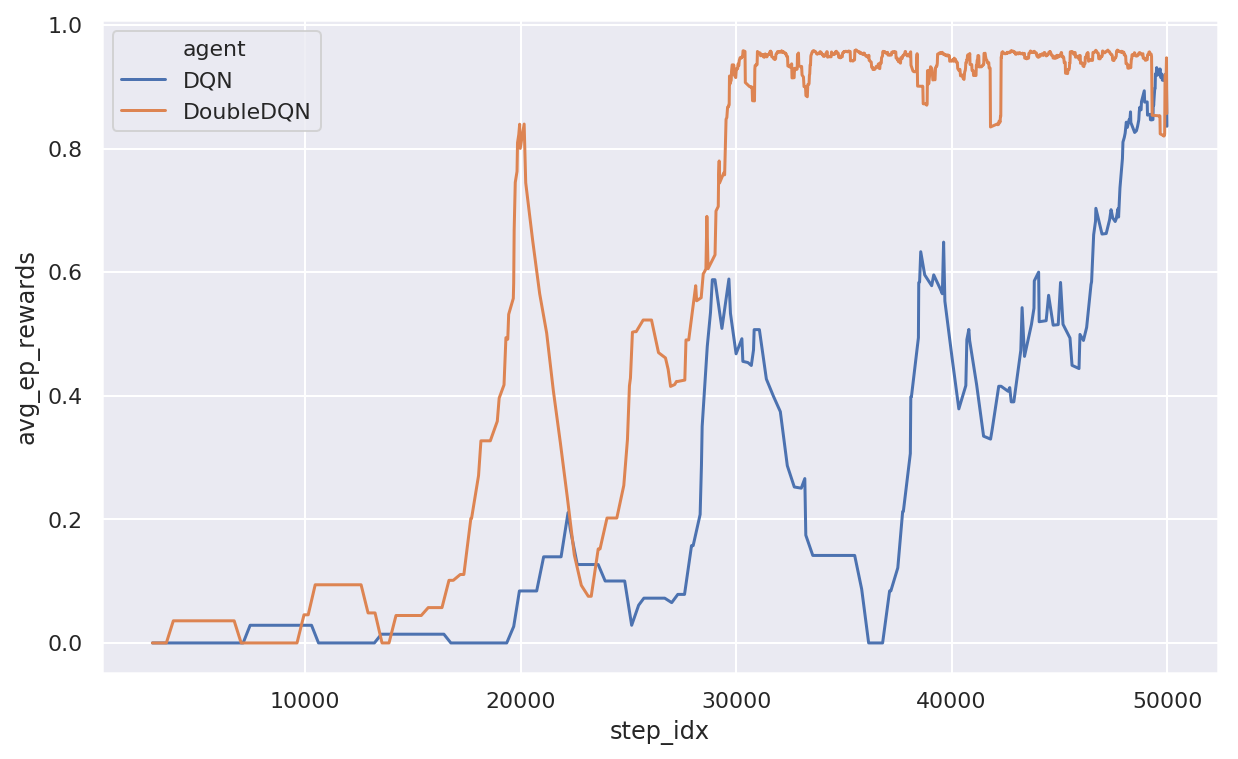

In [0]:
plot_stats(stats, hue="agent")

## 8. Dueling DQN

### BONUS TASK: Implement Dueling DQN and compare it on any env you want with the other two methods.

Extra-credits for showing statistically-relevant graphs, unlike I did in
this lab.

In [0]:
# Dueling DQN can be implemented fairly easy by defining a new 
# nn.Module instead of the one returned by `get_estimator()`.
# It can **probably** be used with both DQN and DoubleDQN as they are.


class DuelingNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DuelingNet, self).__init__()
        # define convolutional feature extractor
        # advantage layers
        # value layers
    
    def forward(self, x):
        pass


class DuelingDQN(DQN):
    pass